In [28]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings("ignore")

#READING BOOKS DATASET I.E. BOOKS.CSV FILE
book_data=pd.read_csv('Dataset/Books.csv',header=[0])
#ratings_data=pd.read_csv('Dataset/Ratings.csv',header=[0])
#book_data.describe()
#book_data.describe()
#ratings_data.describe()

#DATA CLEANING(BOOKS.CSV)

book_data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
#book_data.head()

book_data.isnull().sum() 

book_data.loc[book_data['Book-Author'].isnull(),:]

book_data.loc[book_data['Publisher'].isnull(),:]

book_data.at[187689 ,'Book-Author'] = 'Other'
book_data.at[128890 ,'Publisher'] = 'Other'
book_data.at[129037 ,'Publisher'] = 'Other'

book_data['Year-Of-Publication'].unique()

#pd.set_option('display.max_colwidth', -1)
book_data.loc[book_data['Year-Of-Publication'] == 'DK Publishing Inc',:]

book_data.loc[book_data['Year-Of-Publication'] == 'Gallimard',:]

book_data.at[209538 ,'Publisher'] = 'DK Publishing Inc'
book_data.at[209538 ,'Year-Of-Publication'] = 2000
book_data.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
book_data.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

book_data.at[221678 ,'Publisher'] = 'DK Publishing Inc'
book_data.at[221678 ,'Year-Of-Publication'] = 2000
book_data.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
book_data.at[209538 ,'Book-Author'] = 'James Buckley'

book_data.at[220731 ,'Publisher'] = 'Gallimard'
book_data.at[220731 ,'Year-Of-Publication'] = '2003'
book_data.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
book_data.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

book_data['Year-Of-Publication'] = book_data['Year-Of-Publication'].astype(int)

book_data.loc[book_data['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
book_data.loc[book_data['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

book_data['ISBN'] = book_data['ISBN'].str.upper()

book_data.drop_duplicates(keep='last', inplace=True) 
book_data.reset_index(drop = True, inplace = True)

##READING USERS DATASET I.E. USERS.CSV FILE

users=pd.read_csv('Dataset/Users.csv',header=[0])

##DATA CLEANING(USERS.CSV)
## Checking null values
print(users.isna().sum())

users.drop(['Location'], axis=1, inplace=True)
#print(users.info())

users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)
#print(users.info())

##READING USERS DATASET I.E. USERS.CSV FILE

ratings=pd.read_csv('Dataset/Ratings.csv',header=[0])

print("Columns: ", list(ratings.columns))
#ratings.info()

#Ratings dataset cleaning
ratings.isnull().sum() 

ratings['ISBN'] = ratings['ISBN'].str.upper()

ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

#MERGING DATASETS(BOOKS.CSV, USERS.CSV, RATINGS.CSV)
dataset = pd.merge(book_data, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
#dataset.info()
#dataset.head()

dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
#dataset1.info()

dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
#dataset2.shape

In [29]:
#WEIGHTED AVERAGE

df1 = pd.DataFrame(dataset1['Book-Title'].value_counts())
df1['Total-Ratings'] = df1['Book-Title']
df1['Book-Title'] = df1.index
df1.reset_index(level=0, inplace=True)
df1 = df1.drop('index',axis=1)
df1 = pd.read_pickle('weightedData')

def avgRating(newdf, df):
    newdf['Average Rating'] = 0
    for x in range(len(newdf)):
        l = list(df.loc[df['Book-Title'] == newdf['Book-Title'][x]]['Book-Rating'])
        newdf['Average Rating'][x] = sum(l)/len(l)
    return newdf

## C - Mean vote across the whole
C = df1['Average Rating'].mean()

## Minimum number of ratings required to be in the chart
m = df1['Total-Ratings'].quantile(0.90)

def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

df1 = df1.loc[df1['Total-Ratings'] >= m]

df1['score'] = df1.apply(weighted_rating, axis=1)
df1 = df1.sort_values('score', ascending=False)

print("Recommended Books:-\n")
df1.head(5)

Recommended Books:-



,Book-Title,Total-Ratings,Average Rating,score
4794,Postmarked Yesteryear: 30 Rare Holiday Postcards,11,10,9.189906
7272,The Sneetches and Other Stories,8,10,9.002961
17,Harry Potter and the Prisoner of Azkaban (Book 3),277,9,8.971768
28,Harry Potter and the Goblet of Fire (Book 4),247,9,8.968407
42,Harry Potter and the Order of the Phoenix (Boo...,211,9,8.963141


In [32]:
#Book By Same Author and Same Publisher of given book

def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    d = dataframe[dataframe['Book-Title'] == bookName]
    #print(d)
    au = d['Book-Author'].unique()
    print(au)
    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = d['Publisher'].unique()
    print(au)
    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)
bookName=input("Enter book name") # Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
number=int(input("Enter number of books to be recommended"))

if bookName in list(dataset1['Book-Title'].unique()):
    get_books(dataset1, bookName, number)
else:
    print("Invalid Book Name!!")

Enter book nameHarry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to be recommended5

Books by same Author:

['J. K. Rowling']
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)


Books by same Publisher:

['Arthur A. Levine Books']
The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


In [79]:
#Collaborative Using Cosine Vector Similarity Metric 


#claculates total-ratings each book got and creates a new dataframe having columns bt,isbn,ba,ui,br,tr
cos_avg=[]
for i in range(5):
    noofrec=int(input())
    bookName=input()
    df = pd.DataFrame(dataset1['Book-Title'].value_counts())
    df['Total-Ratings'] = df['Book-Title']
    df['Book-Title'] = df.index
    df.reset_index(level=0, inplace=True)
    df = df.drop('index',axis=1)
    df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
    df = df.drop(['Year-Of-Publication','Publisher','Age'], axis=1)
    #print(df.head(10))
    popularity_threshold = 80
    popular_book = df[df['Total-Ratings'] >= popularity_threshold]
    popular_book = popular_book.reset_index(drop = True)

    testdf = pd.DataFrame()
    testdf['ISBN'] = popular_book['ISBN']
    testdf['Book-Rating'] = popular_book['Book-Rating']
    testdf['User-ID'] = popular_book['User-ID']
    testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])
    #print(testdf.groups) #have the data of users who rated each individual book
    #print(dataset1.info())

    listOfDictonaries=[]
    indexMap = {}
    reverseIndexMap = {}
    ptr=0

    for groupKey in testdf.groups.keys():
        tempDict={}
        groupDF = testdf.get_group(groupKey)
        groupDF= groupDF.reset_index(drop = True)
        for i in range(0,len(groupDF)):
            tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1] #[i,0]=user-id [i,1]=rating
        #in tempdict key=userid value=rating
        indexMap[ptr]=groupKey #indexMap has isbn values
        reverseIndexMap[groupKey] = ptr
        ptr=ptr+1
        listOfDictonaries.append(tempDict) 

    dictVectorizer = DictVectorizer(sparse=True)
    vector = dictVectorizer.fit_transform(listOfDictonaries)
    #print(vector)
   
    pairwiseSimilarity = cosine_similarity(vector)

    def printBookDetails(bookID):
        print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])


    def getTopRecommandations(bookID):
        collaborative = []
        row = reverseIndexMap[bookID]
        print("Input Book for no.of recommendations :",noofrec)
        printBookDetails(bookID)

        print("\nRECOMMENDATIONS:\n")

        mn = 0
        similar = []
        for i in np.argsort(pairwiseSimilarity[row])[::-1]:
              if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:

                    if mn>=(noofrec):
                          break
                    mn+=1
                    similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    printBookDetails(indexMap[i])
                    collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    #collaborative.append(pairwiseSimilarity[i][np.argsort(pairwiseSimilarity[i])[::-1][0]])

        return collaborative

    k = list(dataset1['Book-Title'])
    m = list(dataset1['ISBN'])
    collaborative = getTopRecommandations(m[k.index(bookName)])
    
    l=[]
    for i in collaborative:
        l.append(df1.loc[df1['Book-Title']==i,'score'].tolist()[0])
    cos_avg.append(np.mean(l))
        #print(cos_avg)
        #print(collaborative)
        

#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))  - 5


5
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Input Book for no.of recommendations : 5
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
10
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Input Book for no.of recommendations : 10
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Fried Green Tomatoes at the Whistle Stop Cafe
The Two Towers (The Lord of the Rings, Part 2)
T

In [80]:
print(cos_avg)

[8.577022766764113, 8.37132175018883, 7.983189493961995, 7.886898469402264, 7.790415496160761]


In [81]:
#Collaborative Using Euclidean Distance Similarity Metric 

from sklearn.metrics.pairwise import euclidean_distances

#claculates total-ratings each book got and creates a new dataframe having columns bt,isbn,ba,ui,br,tr
euc_avg=[]
for i in range(5):
    noofrec=int(input())
    bookName=input()
    df = pd.DataFrame(dataset1['Book-Title'].value_counts())
    df['Total-Ratings'] = df['Book-Title']
    df['Book-Title'] = df.index
    df.reset_index(level=0, inplace=True)
    df = df.drop('index',axis=1)
    df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
    df = df.drop(['Year-Of-Publication','Publisher','Age'], axis=1)
    #print(df.head(10))
    popularity_threshold = 80
    popular_book = df[df['Total-Ratings'] >= popularity_threshold]
    popular_book = popular_book.reset_index(drop = True)

    testdf = pd.DataFrame()
    testdf['ISBN'] = popular_book['ISBN']
    testdf['Book-Rating'] = popular_book['Book-Rating']
    testdf['User-ID'] = popular_book['User-ID']
    testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])
    #print(testdf.groups) #have the data of users who rated each individual book
    #print(dataset1.info())

    listOfDictonaries=[]
    indexMap = {}
    reverseIndexMap = {}
    ptr=0

    for groupKey in testdf.groups.keys():
        tempDict={}
        groupDF = testdf.get_group(groupKey)
        groupDF= groupDF.reset_index(drop = True)
        for i in range(0,len(groupDF)):
            tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1] #[i,0]=user-id [i,1]=rating
        #in tempdict key=userid value=rating
        indexMap[ptr]=groupKey #indexMap has isbn values
        reverseIndexMap[groupKey] = ptr
        ptr=ptr+1
        listOfDictonaries.append(tempDict) 

    dictVectorizer = DictVectorizer(sparse=True)
    vector = dictVectorizer.fit_transform(listOfDictonaries)
    #print(vector)
    #pairwiseSimilarity = cosine_similarity(vector)
    pairwiseSimilarity = euclidean_distances(vector)

    def printBookDetails(bookID):
        print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])


    def getTopRecommandations(bookID):
        collaborative = []
        row = reverseIndexMap[bookID]
        print("Input Book for no.of recommendations :",noofrec)
        printBookDetails(bookID)

        print("\nRECOMMENDATIONS:\n")

        mn = 0
        similar = []
        for i in np.argsort(pairwiseSimilarity[row])[::-1]:
              if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:

                    if mn>=(noofrec):
                          break
                    mn+=1
                    similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    printBookDetails(indexMap[i])
                    collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    #collaborative.append(pairwiseSimilarity[i][np.argsort(pairwiseSimilarity[i])[::-1][0]])

        return collaborative

    k = list(dataset1['Book-Title'])
    m = list(dataset1['ISBN'])
    collaborative = getTopRecommandations(m[k.index(bookName)])
    
    l=[]
    for i in collaborative:
        l.append(df1.loc[df1['Book-Title']==i,'score'].tolist()[0])
    euc_avg.append(np.mean(l))
        #print(cos_avg)
        #print(collaborative)
        

#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))  - 5

5
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Input Book for no.of recommendations : 5
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

The Lovely Bones: A Novel
The Da Vinci Code
The Red Tent (Bestselling Backlist)
The Secret Life of Bees
Divine Secrets of the Ya-Ya Sisterhood: A Novel
10
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Input Book for no.of recommendations : 10
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

The Lovely Bones: A Novel
The Da Vinci Code
The Red Tent (Bestselling Backlist)
The Secret Life of Bees
Divine Secrets of the Ya-Ya Sisterhood: A Novel
Where the Heart Is (Oprah's Book Club (Paperback))
Angels &amp; Demons
Girl with a Pearl Earring
To Kill a Mockingbird
Snow Falling on Cedars
15
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Input Book for no.of recommendations : 15
Harry Potter and the Sorcerer's Stone (Harry Potter (Paper

In [83]:
print(cos_avg)
print(euc_avg)

[8.577022766764113, 8.37132175018883, 7.983189493961995, 7.886898469402264, 7.790415496160761]
[7.796282970122135, 7.696573723893506, 7.597401764541159, 7.497112020680673, 7.399209583282852]


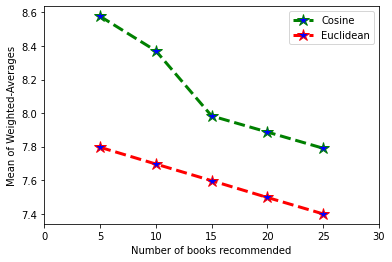

In [89]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([5,10,15,20,25],cos_avg,label='Cosine',color='green', linestyle='dashed', linewidth = 3,
         marker='*', markerfacecolor='blue', markersize=12); 
ax.plot([5,10,15,20,25],euc_avg,label='Euclidean',color='red', linestyle='dashed', linewidth = 3,
         marker='*', markerfacecolor='blue', markersize=12);
plt.xlim(0,30)
ax.set_xlabel('Number of books recommended') 
ax.set_ylabel('Mean of Weighted-Averages')  
ax.legend();
#Mean of Weighted-Average ratings of the books recommended

In [55]:
#Test Case 1: For different input book
#Collaborative Using Cosine Vector Similarity Metric 

#claculates total-ratings each book got and creates a new dataframe having columns bt,isbn,ba,ui,br,tr
cos_avg=[]
for i in range(6):
    noofrec=int(input())
    bookName=input()
    df = pd.DataFrame(dataset1['Book-Title'].value_counts())
    df['Total-Ratings'] = df['Book-Title']
    df['Book-Title'] = df.index
    df.reset_index(level=0, inplace=True)
    df = df.drop('index',axis=1)
    df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
    df = df.drop(['Year-Of-Publication','Publisher','Age'], axis=1)
    #print(df.head(10))
    popularity_threshold = 80
    popular_book = df[df['Total-Ratings'] >= popularity_threshold]
    popular_book = popular_book.reset_index(drop = True)

    testdf = pd.DataFrame()
    testdf['ISBN'] = popular_book['ISBN']
    testdf['Book-Rating'] = popular_book['Book-Rating']
    testdf['User-ID'] = popular_book['User-ID']
    testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])
    #print(testdf.groups) #have the data of users who rated each individual book
    #print(dataset1.info())

    listOfDictonaries=[]
    indexMap = {}
    reverseIndexMap = {}
    ptr=0

    for groupKey in testdf.groups.keys():
        tempDict={}
        groupDF = testdf.get_group(groupKey)
        groupDF= groupDF.reset_index(drop = True)
        for i in range(0,len(groupDF)):
            tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1] #[i,0]=user-id [i,1]=rating
        #in tempdict key=userid value=rating
        indexMap[ptr]=groupKey #indexMap has isbn values
        reverseIndexMap[groupKey] = ptr
        ptr=ptr+1
        listOfDictonaries.append(tempDict) 

    dictVectorizer = DictVectorizer(sparse=True)
    vector = dictVectorizer.fit_transform(listOfDictonaries)
    #print(vector)
    #pairwiseSimilarity = cosine_similarity(vector)
    pairwiseSimilarity = cosine_similarity(vector)

    def printBookDetails(bookID):
        print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])


    def getTopRecommandations(bookID):
        collaborative = []
        row = reverseIndexMap[bookID]
        print("Input Book for no.of recommendations :",noofrec)
        printBookDetails(bookID)

        print("\nRECOMMENDATIONS:\n")

        mn = 0
        similar = []
        for i in np.argsort(pairwiseSimilarity[row])[::-1]:
              if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:

                    if mn>=(noofrec):
                          break
                    mn+=1
                    similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    printBookDetails(indexMap[i])
                    collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    #collaborative.append(pairwiseSimilarity[i][np.argsort(pairwiseSimilarity[i])[::-1][0]])

        return collaborative

    k = list(dataset1['Book-Title'])
    m = list(dataset1['ISBN'])
    collaborative = getTopRecommandations(m[k.index(bookName)])
    
    l=[]
    for i in collaborative:
        l.append(df1.loc[df1['Book-Title']==i,'score'].tolist()[0])
    cos_avg.append(np.mean(l))
        #print(cos_avg)
        #print(collaborative)
        

#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))  - 5


5
Harry Potter and the Goblet of Fire (Book 4)
Input Book for no.of recommendations : 5
Harry Potter and the Goblet of Fire (Book 4)

RECOMMENDATIONS:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Order of the Phoenix (Book 5)
10
Harry Potter and the Goblet of Fire (Book 4)
Input Book for no.of recommendations : 10
Harry Potter and the Goblet of Fire (Book 4)

RECOMMENDATIONS:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
The Two Towers (The Lord of the Rings, Part 2)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Return of the King (The Lord of the

In [57]:
#Collaborative Using Euclidean Distance Similarity Metric 

from sklearn.metrics.pairwise import euclidean_distances

#claculates total-ratings each book got and creates a new dataframe having columns bt,isbn,ba,ui,br,tr
euc_avg=[]
for i in range(6):
    noofrec=int(input())
    bookName=input()
    df = pd.DataFrame(dataset1['Book-Title'].value_counts())
    df['Total-Ratings'] = df['Book-Title']
    df['Book-Title'] = df.index
    df.reset_index(level=0, inplace=True)
    df = df.drop('index',axis=1)
    df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
    df = df.drop(['Year-Of-Publication','Publisher','Age'], axis=1)
    #print(df.head(10))
    popularity_threshold = 80
    popular_book = df[df['Total-Ratings'] >= popularity_threshold]
    popular_book = popular_book.reset_index(drop = True)

    testdf = pd.DataFrame()
    testdf['ISBN'] = popular_book['ISBN']
    testdf['Book-Rating'] = popular_book['Book-Rating']
    testdf['User-ID'] = popular_book['User-ID']
    testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])
    #print(testdf.groups) #have the data of users who rated each individual book
    #print(dataset1.info())

    listOfDictonaries=[]
    indexMap = {}
    reverseIndexMap = {}
    ptr=0

    for groupKey in testdf.groups.keys():
        tempDict={}
        groupDF = testdf.get_group(groupKey)
        groupDF= groupDF.reset_index(drop = True)
        for i in range(0,len(groupDF)):
            tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1] #[i,0]=user-id [i,1]=rating
        #in tempdict key=userid value=rating
        indexMap[ptr]=groupKey #indexMap has isbn values
        reverseIndexMap[groupKey] = ptr
        ptr=ptr+1
        listOfDictonaries.append(tempDict) 

    dictVectorizer = DictVectorizer(sparse=True)
    vector = dictVectorizer.fit_transform(listOfDictonaries)
    #print(vector)
    #pairwiseSimilarity = cosine_similarity(vector)
    pairwiseSimilarity = euclidean_distances(vector)

    def printBookDetails(bookID):
        print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])


    def getTopRecommandations(bookID):
        collaborative = []
        row = reverseIndexMap[bookID]
        print("Input Book for no.of recommendations :",noofrec)
        printBookDetails(bookID)

        print("\nRECOMMENDATIONS:\n")

        mn = 0
        similar = []
        for i in np.argsort(pairwiseSimilarity[row])[::-1]:
              if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:

                    if mn>=(noofrec):
                          break
                    mn+=1
                    similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    printBookDetails(indexMap[i])
                    collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                    #collaborative.append(pairwiseSimilarity[i][np.argsort(pairwiseSimilarity[i])[::-1][0]])

        return collaborative

    k = list(dataset1['Book-Title'])
    m = list(dataset1['ISBN'])
    collaborative = getTopRecommandations(m[k.index(bookName)])
    
    l=[]
    for i in collaborative:
        l.append(df1.loc[df1['Book-Title']==i,'score'].tolist()[0])
    euc_avg.append(np.mean(l))
        #print(cos_avg)
        #print(collaborative)
        

#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))  - 5

5
Harry Potter and the Goblet of Fire (Book 4)
Input Book for no.of recommendations : 5
Harry Potter and the Goblet of Fire (Book 4)

RECOMMENDATIONS:

The Lovely Bones: A Novel
The Da Vinci Code
The Red Tent (Bestselling Backlist)
The Secret Life of Bees
Divine Secrets of the Ya-Ya Sisterhood: A Novel
10
Harry Potter and the Goblet of Fire (Book 4)
Input Book for no.of recommendations : 10
Harry Potter and the Goblet of Fire (Book 4)

RECOMMENDATIONS:

The Lovely Bones: A Novel
The Da Vinci Code
The Red Tent (Bestselling Backlist)
The Secret Life of Bees
Divine Secrets of the Ya-Ya Sisterhood: A Novel
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Where the Heart Is (Oprah's Book Club (Paperback))
Girl with a Pearl Earring
Angels &amp; Demons
To Kill a Mockingbird
15
Harry Potter and the Goblet of Fire (Book 4)
Input Book for no.of recommendations : 15
Harry Potter and the Goblet of Fire (Book 4)

RECOMMENDATIONS:

The Lovely Bones: A Novel
The Da Vinci Code
The Red 

In [58]:
print(cos_avg)
print(euc_avg)

[8.770076465933977, 8.47202741074407, 7.9848400138931845, 7.790689450609468, 7.674344762221585, 7.691809021109331]
[7.796282970122135, 7.79492021950001, 7.663046052022495, 7.497441131401674, 7.438498046964372, 7.3994401587342935]


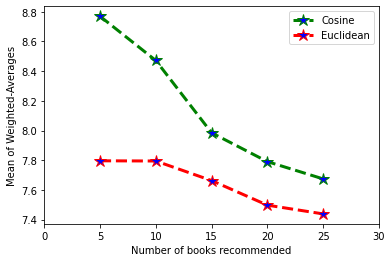

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([5,10,15,20,25],cos_avg,label='Cosine',color='green', linestyle='dashed', linewidth = 3,
         marker='*', markerfacecolor='blue', markersize=12); 
ax.plot([5,10,15,20,25],euc_avg,label='Euclidean',color='red', linestyle='dashed', linewidth = 3,
         marker='*', markerfacecolor='blue', markersize=12);
plt.xlim(0,30)
ax.set_xlabel('Number of books recommended') 
ax.set_ylabel('Mean of Weighted-Averages')  
ax.legend();
#Mean of Weighted-Average ratings of the books recommended
#Harry Potter and the Goblet of Fire (Book 4)

In [52]:
#RMSE Calculation Code

dataset.rename(columns = {'User-ID':'UserID'}, inplace = True)

from sklearn import model_selection
train_data, test_data = model_selection.train_test_split(dataset, test_size=0.20)

print(f'Training set lengths: {len(train_data)}')
print(f'Testing set lengths: {len(test_data)}')
print(f'Test set is {(len(test_data)/(len(train_data)+len(test_data))*100):.0f}% of the full dataset.')

# Get int mapping for user_id in train dataset

u_unique_train = train_data.UserID.unique()  
train_data_user2idx = {o:i for i, o in enumerate(u_unique_train)}

# Get int mapping for isbn in train dataset

i_unique_train = train_data.ISBN.unique()  
train_data_book2idx = {o:i for i, o in enumerate(i_unique_train)}

# Get int mapping for user_id in test dataset

u_unique_test = test_data.UserID.unique()  
test_data_user2idx = {o:i for i, o in enumerate(u_unique_test)}

# Get int mapping for isbn in train dataset

i_unique_test = test_data.ISBN.unique() 
test_data_book2idx = {o:i for i, o in enumerate(i_unique_test)}

# TRAINING SET
train_data['u_unique'] = train_data['UserID'].map(train_data_user2idx)
train_data['i_unique'] = train_data['ISBN'].map(train_data_book2idx)

# TESTING SET
test_data['u_unique'] = test_data['UserID'].map(test_data_user2idx)
test_data['i_unique'] = test_data['ISBN'].map(test_data_book2idx)

# Convert back to 3-column df
train_data = train_data[['u_unique', 'i_unique', 'Book-Rating']]
test_data = test_data[['u_unique', 'i_unique', 'Book-Rating']]

for entry in train_data.itertuples():
    print(entry)

n_users = train_data['u_unique'].nunique()
n_books = train_data['i_unique'].nunique()

train_matrix = np.zeros((n_users, n_books))

for entry in train_data.itertuples():                  # entry[1] is the user-id, entry[2] is the book-isbn
    train_matrix[entry[1]-1, entry[2]-1] = entry[3]    # -1 is to counter 0-based indexing

n_users = test_data['u_unique'].nunique()
n_books = test_data['i_unique'].nunique()

test_matrix = np.zeros((n_users, n_books))

for entry in test_data.itertuples():
    test_matrix[entry[1]-1, entry[2]-1] = entry[3] 

train_matrix_small = train_matrix[:5000, :5000]
test_matrix_small = test_matrix[:5000, :5000]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_small, metric='cosine')
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine')

def predict_books(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

item_prediction = predict_books(train_matrix_small, item_similarity, type='item')
user_prediction = predict_books(train_matrix_small, user_similarity, type='user')

from sklearn.metrics import me+1

def rmse(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test_matrix))

print(f'Item-based CF RMSE: {rmse(item_prediction, test_matrix_small)}')
print(f'User-based CF RMSE: {rmse(user_prediction, test_matrix_small)}')


Item-based CF RMSE: 8.06252302071467
User-based CF RMSE: 8.062458873930925
